In [1]:
from __future__ import annotations

from helper import generate_2d_ising_observable_data, plot_error_vs_depth

Define parameters

In [2]:
J = 1
g = 0.5
dt = 0.1
num_rows = 4
num_cols = 5
pad = 1

thresholds = [0]
max_bonds = [256]
timesteps_list = range(1, 5)

In [3]:
results = generate_2d_ising_observable_data(num_rows, num_cols, J, g, dt, pad, thresholds, max_bonds, timesteps_list)

In [4]:
import operator

import matplotlib.pyplot as plt


def plot_error_vs_depth(results, bond_dims) -> None:
    # Create a 1xN figure (one subplot per threshold)
    _fig, axes = plt.subplots(2, 1, sharex=True)
    # Map bond dimensions to distinct colors
    color_map = {4: "red", 8: "green", 16: "blue", 32: "black", 64: "black", 256: "black"}
    # Use different markers for each simulator
    marker_map = {"TEBD": "o", "TDVP": "^"}

    axes[0].set_title("Infidelity")
    axes[1].set_title("Local Observable Error")
    for i, name in enumerate(["infidelity", "error"]):
        ax = axes[i]

        # Create an inset in the lower right corner
        ax_inset = ax.inset_axes([0.55, 0.05, 0.4, 0.4])
        ax_inset.set_title("TDVP Advantage", fontsize=8)
        ax_inset.tick_params(axis="both", labelsize=8)
        ax_inset.set_ylim(0.5e-1, 1e8)
        for bond_dim in bond_dims:
            # Extract data for TEBD and TDVP
            if name == "infidelity":
                tebd_data = [(depth, infid) for (depth, the, bd, infid, err) in results["TEBD"] if bd == bond_dim]
                tdvp_data = [(depth, infid) for (depth, the, bd, infid, err) in results["TDVP"] if bd == bond_dim]
            elif name == "error":
                tebd_data = [(depth, err) for (depth, the, bd, infid, err) in results["TEBD"] if bd == bond_dim]
                tdvp_data = [(depth, err) for (depth, the, bd, infid, err) in results["TDVP"] if bd == bond_dim]

            # Sort by circuit depth
            tebd_data.sort(key=operator.itemgetter(0))
            tdvp_data.sort(key=operator.itemgetter(0))

            # Unpack for plotting
            tebd_depths = [x[0] for x in tebd_data]
            tebd_errors = [x[1] for x in tebd_data]
            tdvp_depths = [x[0] for x in tdvp_data]
            tdvp_errors = [x[1] for x in tdvp_data]

            # Plot main curves on the primary axis
            ax.plot(
                tebd_depths,
                tebd_errors,
                label=f"TEBD, bond={bond_dim}" if i == 0 else "",
                color=color_map[bond_dim],
                marker=marker_map["TEBD"],
                linestyle="--",
            )
            ax.plot(
                tdvp_depths,
                tdvp_errors,
                label=f"TDVP, bond={bond_dim}" if i == 0 else "",
                color=color_map[bond_dim],
                marker=marker_map["TDVP"],
                linestyle="-",
            )

            ratio_errors = [te / td for td, te in zip(tdvp_errors, tebd_errors)]
            ax_inset.axhline(1, color="k", linestyle="--")  # reference line at ratio = 1
            # Plot the difference in the inset axis
            ax_inset.plot(
                tdvp_depths,
                ratio_errors,
                label=f"bond={bond_dim}",
                color=color_map[bond_dim],
                marker=marker_map["TDVP"],
                linestyle="-",
            )
            ax_inset.set_yscale("log")

        ax.set_yscale("log")
        ax.set_ylim(1e-16, 5e-1)

        ax.grid(True)

        # Add a horizontal line at 0 in the inset to mark no difference
        ax_inset.axhline(0, color="black", linestyle="--", linewidth=1)

    axes[1].set_ylabel("Circuit depth (Trotter steps)")
    axes[0].set_ylabel("Infidelity (log scale)")
    axes[1].set_ylabel("Local observable error (log scale)")

    axes[0].legend(loc="lower left", fontsize="small")
    axes[0].set_xlabel("Circuit depth (Trotter steps)")
    axes[0].set_xlabel(None)
    plt.tight_layout()
    plt.show()

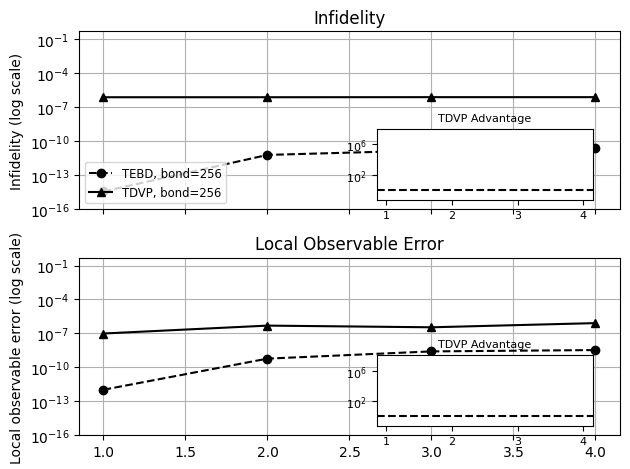

In [5]:
plot_error_vs_depth(results, max_bonds)